# kdh FINAL Project - The Battle of the Neighborhoods 
### *for Applied Data Science Capstone Course*

## Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction <a name="introduction"></a>

This project strives to **identify the Southern California neighborhoods that are at high risk for severe impact from COVID-19**, the disease caused by the novel coronavirus (SARS-cov-2). 

Over 2.5 million cases of COVID-19 have been reported worldwide (as of late-April 2020) with over 190,000 deaths.  This is the biggest global health event in the 21st century and the spread of the coronavirus and its potential impact upon specific communities has become a paramount concern to cities and governments everywhere, including Southern California (SoCal).

Two key factors that have been cited as being correlated to the likelihood of contracting COVID-19 *are population density and availability of hospital beds.*  We will look at these factors and use data science techniques to combine relevant data with geographical locations to **map by SoCal neighborhood those areas that the data show have highest risk for COVID-19**.  

This map and the data behind it will allow civic and other leaders in Southern California to clearly see where they need to take mitigating steps (like arranging for additional hospital beds or imposing social distancing measures) that could save lives.



## Data <a name="data"></a>

Here is the key data needed to complete this project:
* population by SoCal zip code downloaded from **US Census using their public API**
* SoCal hospital name and latitude/longitude gathered using **Foursquare API**
* SoCal hospital name, city and number of beds scraped from **American Hospital Directory website https://www.ahd.com/states/hospital_CA.html**
* COVID-19 overall hospitalization rate calculated from data downloaded from **NYC Health website https://www1.nyc.gov/site/doh/covid/covid-19-data.page**  (New York City is similar in size to the SoCal region and has the most COVID data)
* geocoordinates from **geopy and Nominatum** for Los Angeles, CA as an appropriate centerpoint to map SoCal using **Folium**

NOTE: zip code was chosen as the core measure (rather than city or county) to provide the most granular information.  this will allow Los Angeles to be split into its far-ranging geographic communities (e.g. Century City & Westwood & Downtown Los Angeles) rather than just lumping all LA population data into one widespread blob called Los Angeles.  

Will also need this supplemental data to aid presentation and ease comprehension:
* cross-reference of SoCal zipcodes to their corresponding city using scraped & filtered data from **https://www.laalmanac.com/communications/cm02_communities.php**

Here's how the data will be used once gathered:

1. Calculate population and number of beds for each city/community based on zip codes. For example, Beverly Hills has three zip codes 90210, 90211 & 90212
1. Convert population to max # of beds needed for each city/community using the overall hospitalization rate from NYC
1. Calculate the 'bed supply ratio' for each city/community = max # of beds/number of beds (a value < 1 indicates there are enough hospital beds to cover the max # of beds needed; a number > 1 indicates a possible shortage of beds)
1. Assign each zip code in a city or community the 'bed supply ratio' for that city or community
1. Plot the 'bed supply ratio' for each zip code on a thematic map of SoCal visually highlighting the high risk areas
1. Plot each hospital on that SoCal map with its name and number of beds appearing when clicked
1. Tabulate the 10 least at risk communities 



### DATA GATHERING, CLEANING AND WRANGLING

In [1]:
import pandas as pd
import numpy as np
import requests

### **Communities and Zip Codes**

Get the zip codes for various communities by scraping this website https://www.laalmanac.com/communications/cm02_communities.php

In [2]:
!pip install lxml

     |████████████████████████████████| 5.8MB 11.4MB/s eta 0:00:01


In [3]:
# read_html by pretending to be a browser
url = 'https://www.laalmanac.com/communications/cm02_communities.php'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

dfz = pd.read_html(r.text)
df_zipz = dfz[0]  #there's only one table
df_zipz.head(2)

City/Community Zip Code(s)
0          Acton       93510
1   Agoura Hills       91301

In [4]:
df_zipz.shape

(643, 2)

In [5]:
df_zipz.head(8)

City/Community          Zip Code(s)
0                                            Acton                93510
1                                     Agoura Hills                91301
2                          Agoura Hills (PO Boxes)                91376
3                                       Agua Dulce                91390
4                                         Alhambra         91801, 91803
5  Alhambra (Non-Geographic Zip Code Within 91801)                91804
6                              Alhambra (PO Boxes)  91802, 91896, 91899
7                                         Altadena                91001

Closer review of zip code community data reveals neighborhoods in LA and Long Beach are appearing twice:  once as Los Angeles (Neighborhood) and again as Neighborhood   (Los Angeles).  We only need the latter appearance, so we'll exclude all rows that begin with 'Los Angeles' or 'Long Beach'

In [6]:
df_zipz=df_zipz[~df_zipz['City/Community'].str.startswith(('Los Angeles', 'Long Beach'))]

In [7]:
df_zipz.shape

(473, 2)

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [9]:
#let's data wrangle the zips, first split the columns into extra rows
df_zipz1=(df_zipz.set_index(['City/Community'])
   .stack()
   .str.split(',', expand=True)
   .stack()
   .unstack(-2)
   .reset_index(-1, drop=True)
   .reset_index()
)

In [10]:
df_zipz1.head(25)

City/Community Zip Code(s)
0                                               Acton       93510
1                                        Agoura Hills       91301
2                             Agoura Hills (PO Boxes)       91376
3                                          Agua Dulce       91390
4                                            Alhambra       91801
5                                            Alhambra       91803
6     Alhambra (Non-Geographic Zip Code Within 91801)       91804
7                                 Alhambra (PO Boxes)       91802
8                                 Alhambra (PO Boxes)       91896
9                                 Alhambra (PO Boxes)       91899
10                                           Altadena       91001
11                                Altadena (PO Boxes)       91003
12  Americana at Brand & Glendale Galleria (Glendale)       91210
13                                            Arcadia       91006
14                                            Arcadia       91007
15                                 Arcadia (PO Boxes)       91066
16                                 Arcadia (PO Boxes)       91077
17                               Arleta (Los Angeles)       91331
18                    Arlington Heights (Los Angeles)       90019
19                                            Artesia       90701
20                                 Artesia (PO Boxes)       90702
21                                             Athens       90044
22                      Atwater Village (Los Angeles)       90039
23                                  Avalon (PO Boxes)       90704
24                                    Avocado Heights       91746

In [226]:
#now remove all the elements in parentheses
df_zipz1['City/Community']=df_zipz1['City/Community'].str.replace(r"\(.*\)","")
df_zipz1.head()

City/Community Zip Code(s)
0          Acton       93510
1   Agoura Hills       91301
2  Agoura Hills        91376
3     Agua Dulce       91390
4       Alhambra       91801

During data wrangling below, learned Long Beach (unlike Los Angeles) has one community with several zipcodes that doesn't have a neighborhood (name); so, let's add that back to df_zipz1

In [12]:
#df = pd.DataFrame(data, columns = ['Name', 'Age'])
data = [['Long Beach', 90802], ['Long Beach', 90806], ['Long Beach', 90808], ['Long Beach', 90810], ['Long Beach', 90813], ['Long Beach', 90814], ['Long Beach', 90815], ['Long Beach', 90822], ['Long Beach', 90740]]
df_LB=pd.DataFrame(data,columns = ['City/Community','Zip Code(s)'])
df_LB

City/Community  Zip Code(s)
0     Long Beach        90802
1     Long Beach        90806
2     Long Beach        90808
3     Long Beach        90810
4     Long Beach        90813
5     Long Beach        90814
6     Long Beach        90815
7     Long Beach        90822
8     Long Beach        90740

In [13]:
#append into df_zipz1
df_zipz2 = df_zipz1.append(df_LB, ignore_index=True)
df_zipz2.shape

(732, 2)

In [14]:
#check tail to see if Long Beach zips have been added
df_zipz2.tail(10)

City/Community Zip Code(s)
722  Woodland Hills/Pierce College        91371
723                      Long Beach       90802
724                      Long Beach       90806
725                      Long Beach       90808
726                      Long Beach       90810
727                      Long Beach       90813
728                      Long Beach       90814
729                      Long Beach       90815
730                      Long Beach       90822
731                      Long Beach       90740

In [15]:
#rename columns to match names in other dataframes
df_zipz2.rename(columns={'City/Community': 'City', 'Zip Code(s)': 'ZipCode'}, inplace=True)
df_zipz2.head(2)

City ZipCode
0         Acton   93510
1  Agoura Hills   91301

### **Population by ZipCode** 

Get population data for 2018 American Community Survey (latest available for zip codes) from US Census using their public API 
<br>Data available in csv format

In [16]:
url = 'https://api.census.gov/data/2018/acs/acs5?get=NAME,B01003_001E&for=zip+code+tabulation+area:*&key=5715853990a8ce72a7216dd0f031ee68d57103c1'

In [17]:
df_zip=pd.read_csv(url)

In [18]:
df_zip.head(2)

[["NAME"  B01003_001E zip code tabulation area]  Unnamed: 3
0  ["ZCTA5 43964"         8642                    43964]         NaN
1  ["ZCTA5 28216"        51116                    28216]         NaN

Drop the first and last columns, rename remaining columns as 2018Population and ZipCode, trim ] from rhs of ZipCode and filter on ZipCodes for SoCal only

In [19]:
df_zip.columns=['drop','2018Population','ZipCode','drop2']
df_zip.head(2)

drop  2018Population ZipCode  drop2
0  ["ZCTA5 43964"            8642  43964]    NaN
1  ["ZCTA5 28216"           51116  28216]    NaN

In [20]:
df_zip = df_zip.drop(['drop','drop2'], axis=1)

Remove the trailing ] that came along with the data...

In [21]:
df_zip['ZipCode'] = df_zip['ZipCode'].str.replace(']','')
df_zip.head(2)

2018Population ZipCode
0            8642   43964
1           51116   28216

In [22]:
df_zip.shape

(33120, 2)

We don't need all 33k zip codes, just the ones in SoCal

In [23]:
#LA County zipcodes range from 90000 to 93586, let's call it 93600 to be safe
df_zip['ZipCode'] = df_zip['ZipCode'].astype(int)

In [24]:
df_zip=df_zip[(df_zip['ZipCode'] >= 90000)]

In [25]:
df_zip=df_zip[(df_zip['ZipCode'] <= 93600)]

In [26]:
df_zip.shape

(834, 2)

That's more manageable.  Check the end of the data to see what zips are there...

In [27]:
df_zip.tail()

2018Population  ZipCode
31940              22    93519
31941             168    93524
31942              40    93558
31943              77    93592
31950            4198    93235

In [28]:
#check a random LA area zip code to make sure it's there
df_zip.loc[df_zip['ZipCode'] == 90210]

2018Population  ZipCode
30896           19909    90210

LET'S IMPORT THE OTHER LIBRARIES ETC WE'LL NEED

In [29]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize #not sure this is needed as we used pd.json_normalize in the lab to avoid errors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

Let's use geopy and Nominatum to get **geocoordinates of Los Angeles**; we'll use those in our Foursquare call for hospital data and later to plot maps

In [30]:
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="LA_explorer")
location = geolocator.geocode(address)
lat = location.latitude
lng = location.longitude
print('Los Angeles geocoordinates are {}, {}.'.format(lat, lng))

Los Angeles geocoordinates are 34.0536909, -118.2427666.


### **Foursquare Data**
USE **FOURSQUARE API** TO GET *HOSPITAL NAMES AND LATITUDE/LONGITUDE COORDINATES IN SOUTHERN CALIFORNIA*

First, set Foursquare credentials

In [31]:
CLIENT_ID = 'LRIJEO12JGBDNEPKB42D1KASZJLER4UMNHGYJ4SYFAFMG0QK' 
CLIENT_SECRET = 'SQ1YGPKZJQFUKUK5KEX34531VLE2JOOVXB4QCDW34REW5MTD' 
VERSION = '20180605' 

Let's use 'search' syntax, radius of 50miles, lat/long of Los Angeles as center, query for hospital

In [32]:
radius=80500 #approx 50miles in meters
LIMIT=300  #should be ~250 max 
query="hospital"

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            query)
            
results = requests.get(url).json()
results        

{'meta': {'code': 200, 'requestId': '5ea72b1483525f001bb3606a'},
 'response': {'venues': [{'id': '4b071af3f964a52054f722e3',
    'name': 'Good Samaritan Hospital',
    'location': {'address': '616 Witmer St',
     'lat': 34.054600859321276,
     'lng': -118.26541015878587,
     'labeledLatLngs': [{'label': 'display',
       'lat': 34.054600859321276,
       'lng': -118.26541015878587}],
     'distance': 2090,
     'postalCode': '90017',
     'cc': 'US',
     'city': 'Los Angeles',
     'state': 'CA',
     'country': 'United States',
     'formattedAddress': ['616 Witmer St',
      'Los Angeles, CA 90017',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d196941735',
      'name': 'Hospital',
      'pluralName': 'Hospitals',
      'shortName': 'Hospital',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1588013909',
    'hasPerk': False},
   {'id': '4a7eb4d6f964a5

looked at results and confirmed all desired info lives in 'response''venues' <br> can now normalize json and convert to pandas dataframe

In [33]:
venues = results['response']['venues']    
df_hospitals = pd.json_normalize(venues) # flatten JSON
df_hospitals

id  \
0   4b071af3f964a52054f722e3   
1   4a7eb4d6f964a5200ff21fe3   
2   4d42001faed776ebf42b6a97   
3   4eeeb9894901dff308ccc730   
4   4b46aa5bf964a520852626e3   
5   4c17887b30d30f47fa9f36a9   
6   5da4950c7e10200008541965   
7   5da494aec38e86000876f3fe   
8   4d42001faed776ebff2b6a97   
9   4c38c5292c8020a1e9728b00   
10  4b5896bbf964a520e85f28e3   
11  55cdca99498e32f4bc6db0d7   
12  5163099ae4b02525e22ab9f0   
13  5e1831411166c300078e9bf8   
14  4be087ab4f15c928878bcb0b   
15  4c2f029ded37a593f4926603   
16  4c43b30a36d6a593269269a8   
17  4e128417091adaa956fc5600   
18  4df9133e62e1bb821b6087f2   
19  4b538420f964a520afa027e3   
20  4b71a7aaf964a520fa532de3   
21  4b47d6d5f964a5200e4126e3   
22  4c0aaaff340720a151dc8693   
23  4b80ef4af964a520819230e3   
24  4bc4ec7e0969a5930432636e   
25  4b99497bf964a520437035e3   
26  4aca9a91f964a52082c220e3   
27  4bc39223b492d13a50f1a860   
28  4f56b2c7e4b0ffe1977bee21   
29  4bf72a80508c0f47ed553d31   
30  4b1049bcf964a520106d23e3   
31  4f9d6651e4b065054cfae3ab   
32  4c3fc488cc410f47c6c0a861   
33  4adf2e56f964a520157821e3   
34  4b55ab62f964a52028eb27e3   
35  4bf2c9d0354e9c74f57e2602   
36  536a3673498e9e9d42fbea63   
37  4b2ff2fbf964a52028f324e3   
38  4baa70f4f964a520726a3ae3   
39  4bc9f1d60687ef3b5bd4dacc   
40  4bad1ceff964a520e32e3be3   
41  4b43e928f964a520d5ed25e3   
42  4b678e2bf964a52017552be3   
43  4b82dd38f964a520aae930e3   
44  4b75aee0f964a520b71c2ee3   
45  4b0572edf964a5206b5822e3   
46  4b2efaccf964a520e5e824e3   
47  4be43039cf200f478e93113c   
48  4bfd5b194cf820a17957ecf4   
49  4c3c920b933b0f47ee39e421   

                                                 name  \
0                             Good Samaritan Hospital   
1                  California Hospital Medical Center   
2                Keck Hospital of USC Cafeteria (UNH)   
3                        Good Samaritan Hospital NICU   
4                         Barlow Respiratory Hospital   
5                     Children's Hospital Los Angeles   
6   Keck Medicine of USC - USC Physical Therapy (K...   
7         Keck Medicine of USC - Keck Hospital of USC   
8        Keck Hospital of USC Parking Structure (UHP)   
9                   East Los Angeles Doctors Hospital   
10                       Huntington Memorial Hospital   
11  Emergency Room - California Hospital Medical C...   
12  Los Angeles Center for Women's Health - Califo...   
13  Rehabilitation Department - California Hospita...   
14  USC Norris Comprehensive Cancer Center and Hos...   
15                                    French Hospital   
16                       Kindred Hospital Los Angeles   
17    Orthopaedic Hospital Medical Magnet High School   
18         Gateways Hospital and Mental Health Center   
19                         Glendale Memorial Hospital   
20                    Mattel Children's Hospital UCLA   
21                     PIH Health Hospital - Whittier   
22                                   Beverly Hospital   
23  Santa Monica UCLA Medical Center and Orthopaed...   
24               VCA Miller-Robertson Animal Hospital   
25          Methodist Hospital of Southern California   
26                          VCA Arden Animal Hospital   
27                Beverly Hills Small Animal Hospital   
28                              Banfield Pet Hospital   
29                        VCA Mission Animal Hospital   
30                  VCA A Breed Apart Animal Hospital   
31                     West Hollywood Animal Hospital   
32                  Centinela Hospital Medical Center   
33                   VCA Foothill Veterinary Hospital   
34  Dignity Health Northridge Hospital Medical Center   
35                       PIH Health Hospital - Downey   
36      Southern California Hospital - At Culver City   
37                       Center-Sinai Animal Hospital   
38                         USC Verdugo Hills Hospital   
39                              Banfield Pet Hospital   
40                       Valley Presbyterian Hospital   

we'll want to just get category type (name) from categories column, and filter out some other columns only keeping what we want and need

In [34]:
# define function that extracts the category of the venue
def get_category_type(row):
    categories_list = row['categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [35]:
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng','location.postalCode','location.city']
df_hospitals =df_hospitals.loc[:, filtered_columns]
df_hospitals.head(2)

name  \
0             Good Samaritan Hospital   
1  California Hospital Medical Center   

                                          categories  location.lat  \
0  [{'id': '4bf58dd8d48988d196941735', 'name': 'H...     34.054601   
1  [{'id': '4bf58dd8d48988d196941735', 'name': 'H...     34.037512   

   location.lng location.postalCode location.city  
0   -118.265410               90017   Los Angeles  
1   -118.266257               90015   Los Angeles

In [36]:
# parse the categories column to get only the category name, which should be Hospital
df_hospitals['category'] = df_hospitals.apply(get_category_type, axis=1)
df_hospitals.head(2)

name  \
0             Good Samaritan Hospital   
1  California Hospital Medical Center   

                                          categories  location.lat  \
0  [{'id': '4bf58dd8d48988d196941735', 'name': 'H...     34.054601   
1  [{'id': '4bf58dd8d48988d196941735', 'name': 'H...     34.037512   

   location.lng location.postalCode location.city  category  
0   -118.265410               90017   Los Angeles  Hospital  
1   -118.266257               90015   Los Angeles  Hospital

In [37]:
#delete the original categories column using this syntax del df['column_name']
del df_hospitals['categories']
df_hospitals.head()

name  location.lat  location.lng  \
0               Good Samaritan Hospital     34.054601   -118.265410   
1    California Hospital Medical Center     34.037512   -118.266257   
2  Keck Hospital of USC Cafeteria (UNH)     34.061929   -118.201323   
3          Good Samaritan Hospital NICU     34.054199   -118.265059   
4           Barlow Respiratory Hospital     34.075423   -118.247523   

  location.postalCode location.city           category  
0               90017   Los Angeles           Hospital  
1               90015   Los Angeles           Hospital  
2               90033   Los Angeles  College Cafeteria  
3               90017   Los Angeles           Hospital  
4               90026   Los Angeles           Hospital

In [38]:
#see a category != Hospital, let's see how many of those we have
df_hospitals['category'].value_counts()

Hospital             27
Veterinarian         12
Emergency Room        2
Doctor's Office       2
College Cafeteria     1
High School           1
Medical Center        1
Medical Lab           1
Parking               1
Assisted Living       1
Rehab Center          1
Name: category, dtype: int64

In [39]:
# last cleanup columns by removing the location. prefix
df_hospitals.columns = [col.split(".")[-1] for col in df_hospitals.columns]
df_hospitals.head(2)

name        lat         lng postalCode  \
0             Good Samaritan Hospital  34.054601 -118.265410      90017   
1  California Hospital Medical Center  34.037512 -118.266257      90015   

          city  category  
0  Los Angeles  Hospital  
1  Los Angeles  Hospital

In [40]:
#limit to just those of category = Hospital  
df_hospitals1=df_hospitals[(df_hospitals['category']== 'Hospital')]

there must be more than 25 hospitals within 50miles of DTLA, so let's retry using Foursquare 'explore' syntax

In [41]:
df_hospitals1.shape

(27, 6)

In [42]:
df_hospitals1.head(10)

name        lat         lng  \
0                             Good Samaritan Hospital  34.054601 -118.265410   
1                  California Hospital Medical Center  34.037512 -118.266257   
3                        Good Samaritan Hospital NICU  34.054199 -118.265059   
4                         Barlow Respiratory Hospital  34.075423 -118.247523   
5                     Children's Hospital Los Angeles  34.098062 -118.290349   
10                       Huntington Memorial Hospital  34.133639 -118.152753   
14  USC Norris Comprehensive Cancer Center and Hos...  34.061462 -118.204457   
15                                    French Hospital  34.059826 -118.242478   
18         Gateways Hospital and Mental Health Center  34.085325 -118.256608   
19                         Glendale Memorial Hospital  34.127491 -118.256856   

   postalCode         city  category  
0       90017  Los Angeles  Hospital  
1       90015  Los Angeles  Hospital  
3       90017  Los Angeles  Hospital  
4       90026  Los Angeles  Hospital  
5       90027  Los Angeles  Hospital  
10      91105     Pasadena  Hospital  
14      90089  Los Angeles  Hospital  
15        NaN  Los Angeles  Hospital  
18      90026  Los Angeles  Hospital  
19      91204     Glendale  Hospital

Appears Foursquare doesn't have data on many hospitals in Southern California.  Guess users don't really think to comment on hospitals via Foursquare.  Quick scan of Hospitals in SoCal online indicate there are around 120 or so.  Let's look further...

In [43]:
#slice foursquare hospital data to compare with AHD list and merge
#syntax to use df_beds2=df_beds.iloc[:,0:2]
df4_hosp=df_hospitals1.iloc[:,0:1]
df4_hosp.head(2)

name
0             Good Samaritan Hospital
1  California Hospital Medical Center

In [44]:
#df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)
df4_hosp.rename(columns={'name': 'HospitalName'}, inplace=True)
df4_hosp.head(2)

HospitalName
0             Good Samaritan Hospital
1  California Hospital Medical Center

### **Hospital Beds Data**

Let's scrape hospital beds data from a table on the American Hospital Directory website using pandas read_html

In [45]:
!pip install lxml

In [46]:
dfs = pd. read_html('https://www.ahd.com/states/hospital_CA.html')
df_beds = dfs[1]  #first table was just a title block
df_beds.head()

Hospital Name          City  StaffedBeds  \
0           Adventist Health Simi Valley   Simi Valley          144   
1                 Adventist Ukiah Valley         Ukiah           50   
2                  Downey Medical Center        Downey          352   
3             MarinHealth Medical Center     Greenbrae          235   
4  Providence Saint John's Health Center  Santa Monica          266   

   TotalDischarges  PatientDays Gross PatientRevenue ($000)  
0             6574        26847                    $666,423  
1             3451        12747                    $529,977  
2            15856        70158                  $2,411,332  
3             9248        39395                  $2,216,874  
4            12400        57959                  $1,259,366

In [47]:
#keep only the first three columns df1 = df.iloc[:,0:2]
df_beds1=df_beds.iloc[:,0:3]
df_beds1.head(2)

Hospital Name         City  StaffedBeds
0  Adventist Health Simi Valley  Simi Valley          144
1        Adventist Ukiah Valley        Ukiah           50

In [48]:
df_beds1.shape

(344, 3)

Rename first column to match other dataframes

In [49]:
df_beds1.rename(columns={'Hospital Name': 'HospitalName'}, inplace=True)
df_beds1.head(2)

HospitalName         City  StaffedBeds
0  Adventist Health Simi Valley  Simi Valley          144
1        Adventist Ukiah Valley        Ukiah           50

### **Hospital Latitude/Longitude Data**  

In [50]:
#get another slice to use with opencage, this one with only Hospital Name and City
df_beds2=df_beds.iloc[:,0:2]
df_beds2.head(2)

Hospital Name         City
0  Adventist Health Simi Valley  Simi Valley
1        Adventist Ukiah Valley        Ukiah

In [51]:
!pip install opencage

In [52]:
from opencage.geocoder import OpenCageGeocode
from pprint import pprint

In [53]:
key = '6a8b8cb1511249ca91d186d098cc8a16'

In [54]:
#check to see if OpenCage can return lat/long for a hospital name
geocoder = OpenCageGeocode(key)

query = u'Adventist Health Glendale, Glendale, CA'
results1 = geocoder.geocode(query)
#print(results1)
print(u'%f;%f;%s;%s' % (results1[0]['geometry']['lat'], 
                        results1[0]['geometry']['lng'],
                        results1[0]['components']['postcode'],
                        results1[0]['formatted']
                        ))

34.205188;-118.219972;91020;Adventist Health, Verdugo Boulevard, La Cañada Flintridge, CA 91020, United States of America


In [55]:
#let's try one more just to check 
geocoder = OpenCageGeocode(key)

query = u'Woodland Hills Medical Center, Woodland Hills, CA'
results2 = geocoder.geocode(query)
#print(results2)
print(u'%f;%f;%s' % (results2[0]['geometry']['lat'], 
                        results2[0]['geometry']['lng'],
                        results2[0]['formatted']
                        ))
#this hospital didn't return a zipcode so errored out; need to include some error handling for that...

34.177355;-118.664393;Woodland View Dr, Woodland Hills, CA, United States of America


In [56]:
#do this on full AHD hospital set df_beds2 (takes a couple minutes)
temp1=[]

for a,b in zip(df_beds2['Hospital Name'], df_beds2['City']):

      address = '{}, {}, CA'.format(a,b)
      name = a
      city = b  
      result = geocoder.geocode(address, no_annotations='1')
      longitude = result[0]['geometry']['lng']
      latitude  = result[0]['geometry']['lat']
      temp1.append([name, city, latitude,longitude]) 
       
df_results1=pd.DataFrame(temp1,columns = ['HospitalName', 'City','Latitude','Longitude'])
df_results1 

HospitalName                   City  \
0                         Adventist Health Simi Valley            Simi Valley   
1                               Adventist Ukiah Valley                  Ukiah   
2                                Downey Medical Center                 Downey   
3                           MarinHealth Medical Center              Greenbrae   
4                Providence Saint John's Health Center           Santa Monica   
5                        Woodland Hills Medical Center         Woodland Hills   
6    60th Medical Group - David Grant USAF Medical ...  Travis Air Force Base   
7                         Adventist Health and Rideout             Marysville   
8                         Adventist Health Bakersfield            Bakersfield   
9                            Adventist Health Glendale               Glendale   
10                            Adventist Health Hanford                Hanford   
11                      Adventist Health Lodi Memorial                   Lodi   
12                            Adventist Health Reedley                Reedley   
13                       Adventist Health Saint Helena           Saint Helena   
14                              Adventist Health Selma                  Selma   
15                             Adventist Health Sonora                 Sonora   
16                             Adventist Health Tulare                 Tulare   
17                            Adventist Health Vallejo                Vallejo   
18                     Adventist Health White Memorial            Los Angeles   
19                AHMC Anaheim Regional Medical Center                Anaheim   
20                                    Alameda Hospital                Alameda   
21                    Alhambra Hospital Medical Center               Alhambra   
22                    Alta Bates Summit Medical Center                Oakland   
23     Alta Bates Summit Medical Center Herrick Campus               Berkeley   
24   Alta Bates Summit Medical Center Alta Bates Ca...               Berkeley   
25                    Alvarado Hospital Medical Center              San Diego   
26                       Anaheim Global Medical Center                Anaheim   
27                              Anaheim Medical Center                Anaheim   
28                            Antelope Valley Hospital              Lancaster   
29                              Antioch Medical Center                Antioch   
30                   Arrowhead Regional Medical Center                 Colton   
31                    Arroyo Grande Community Hospital          Arroyo Grande   
32                          Bakersfield Heart Hospital            Bakersfield   
33                       Bakersfield Memorial Hospital            Bakersfield   
34                         Baldwin Park Medical Center           Baldwin Park   
35                          Barstow Community Hospital                Barstow   
36                            Barton Memorial Hospital       South Lake Tahoe   
37                                    Beverly Hospital             Montebello   
38                  California Hospital Medical Center            Los Angeles   
39                     California Mens Colony Hospital        San Luis Obispo   
40     Casa Colina Hospital and Centers for Healthcare                 Pomona   
41                         Cedars-Sinai Medical Center            Los Angeles   
42                   Centinela Hospital Medical Center              Inglewood   
43           CHA Hollywood Presbyterian Medical Center            Los Angeles   
44                       Chapman Global Medical Center                 Orange   
45                                    Chinese Hospital          San Francisco   
46                         Chino Valley Medical Center                  Chino   
47            City of Hope Comprehensive Cancer Center                 Duarte   
48                     Clovis Community Medical Center                 Cl

In [57]:
#limit to hospitals located below Palmdale lat 34.58
df_results2=df_results1[(df_results1['Latitude'] <= 34.58)]
df_results2.shape

(178, 4)

In [58]:
#now limit to hospitals above Long Beach lat 33.77
df_results3=df_results2[(df_results2['Latitude'] >= 33.77)] 
df_results3.shape

(126, 4)

In [59]:
#now run it on df_results3 only 126 rows and scan visually for missing zip codes
for a,b in zip(df_results3['HospitalName'], df_results3['City']):

      address = '{}, {}, CA'.format(a,b)
      name = a
      city = b  
      results4 = geocoder.geocode(address, no_annotations='1')

      print(u'%f;%f;%s,%s' % (results4[0]['geometry']['lat'], 
                        results4[0]['geometry']['lng'],
                        results4[0]['formatted'],
                        name
                        ))

34.289077;-118.745683;Adventist Health Simi Valley, 2975 Sycamore Drive, Simi Valley, CA 93065, United States of America,Adventist Health Simi Valley
33.909190;-118.151840;Downey Avenue, Downey, CA 90706, United States of America,Downey Medical Center
34.030577;-118.479544;Providence Saint John's Health Center, 2121 Santa Monica Boulevard, Santa Monica, CA 90404, United States of America,Providence Saint John's Health Center
34.177355;-118.664393;Woodland View Dr, Woodland Hills, CA, United States of America,Woodland Hills Medical Center
34.205188;-118.219972;Adventist Health, Verdugo Boulevard, La Cañada Flintridge, CA 91020, United States of America,Adventist Health Glendale
36.545915;-119.379748;Adventist Health Medical Office - Dinuba, 1451 East El Monte Way, Dinuba, CA 93618, United States of America,Adventist Health Tulare
34.021201;-118.287271;Watt Way, Los Angeles, CA, United States of America,Adventist Health White Memorial
33.851934;-117.941788;W Medical Center Dr, Anaheim, C

Looks like 80 or so zipcodes returned, have to look up the others manually (boo!), so let's export to Excel, look up and then reimport

IDENTIFY EXTRA HOSPITALS IN FOURSQUARE DATA

In [60]:
#now compare results from OpenCage with Foursquare hospitals data df4_hosp to identify any missing hospitals to add, duplicates etc
dfm = pd.merge( df4_hosp,df_results3, on=['HospitalName'], how='left', indicator='Exist')

In [61]:
dfm1=dfm[dfm['Exist']=='left_only']
dfm1

HospitalName City  Latitude  \
2                        Good Samaritan Hospital NICU  NaN       NaN   
3                         Barlow Respiratory Hospital  NaN       NaN   
4                     Children's Hospital Los Angeles  NaN       NaN   
5                        Huntington Memorial Hospital  NaN       NaN   
6   USC Norris Comprehensive Cancer Center and Hos...  NaN       NaN   
7                                     French Hospital  NaN       NaN   
8          Gateways Hospital and Mental Health Center  NaN       NaN   
9                          Glendale Memorial Hospital  NaN       NaN   
10                    Mattel Children's Hospital UCLA  NaN       NaN   
13  Santa Monica UCLA Medical Center and Orthopaed...  NaN       NaN   
14          Methodist Hospital of Southern California  NaN       NaN   
16  Dignity Health Northridge Hospital Medical Center  NaN       NaN   
18      Southern California Hospital - At Culver City  NaN       NaN   
21                            Animal Medical Hospital  NaN       NaN   
22                              BHC Alhambra Hospital  NaN       NaN   
23                 St John's Hospital & Health Center  NaN       NaN   

    Longitude      Exist  
2         NaN  left_only  
3         NaN  left_only  
4         NaN  left_only  
5         NaN  left_only  
6         NaN  left_only  
7         NaN  left_only  
8         NaN  left_only  
9         NaN  left_only  
10        NaN  left_only  
13        NaN  left_only  
14        NaN  left_only  
16        NaN  left_only  
18        NaN  left_only  
21        NaN  left_only  
22        NaN  left_only  
23        NaN  left_only

Looking at above 16 hospitals that appeared only in Foursquare data, there are just three (Barlow, CHLA and Gateways) are not included in AHD data; we'll gather that info separately and then append at end

In [62]:
#put the data for those three additional hospitals into a dataframe; later found needed to add Providence in San Pedro?
data = {'HospitalName': ['Barlow Respiratory Hospital','Childrens Hospital Los Angeles','Gateways Hospital and Mental Health Center'
                         ,'Providence Little Company of Mary Medical Center San Pedro'],
        'City': ['Echo Park','Hollywood','Echo Park','San Pedro'],'StaffedBeds': [105,603,55,356],'ZipCode': [90026,90027,90026,90732]
        }

df_add = pd.DataFrame (data, columns = ['HospitalName','City', 'StaffedBeds', 'ZipCode'])
df_add

HospitalName       City  StaffedBeds  \
0                        Barlow Respiratory Hospital  Echo Park          105   
1                     Childrens Hospital Los Angeles  Hollywood          603   
2         Gateways Hospital and Mental Health Center  Echo Park           55   
3  Providence Little Company of Mary Medical Cent...  San Pedro          356   

   ZipCode  
0    90026  
1    90027  
2    90026  
3    90732

In [63]:
#slice and use to get lat long from OpenGeo
df1_add = df_add.iloc[:,0:2]
df1_add

HospitalName       City
0                        Barlow Respiratory Hospital  Echo Park
1                     Childrens Hospital Los Angeles  Hollywood
2         Gateways Hospital and Mental Health Center  Echo Park
3  Providence Little Company of Mary Medical Cent...  San Pedro

In [64]:
#get lat long for these add'l hospitals
temp2=[]

for a,b in zip(df1_add['HospitalName'], df1_add['City']):

      address = '{}, {}, CA'.format(a,b)
      name = a
      city = b  
      result = geocoder.geocode(address, no_annotations='1')
      longitude = result[0]['geometry']['lng']
      latitude  = result[0]['geometry']['lat']
      temp2.append([name, city, latitude,longitude]) 
       
df_results4=pd.DataFrame(temp2,columns = ['HospitalName', 'City','Latitude','Longitude'])
df_results4 

HospitalName       City   Latitude  \
0                        Barlow Respiratory Hospital  Echo Park  34.075844   
1                     Childrens Hospital Los Angeles  Hollywood  34.097550   
2         Gateways Hospital and Mental Health Center  Echo Park  34.090010   
3  Providence Little Company of Mary Medical Cent...  San Pedro  33.739339   

    Longitude  
0 -118.248130  
1 -118.290077  
2 -118.259240  
3 -118.306685

Now add these hospitals to the complete AHD/OpenCage dataframe

In [65]:
df_hosp_coords = df_results3.append(df_results4, ignore_index=True)
df_hosp_coords.shape

(130, 4)

In [66]:
#size indicates we've added four rows, let's check at the end to make sure
df_hosp_coords.tail()

HospitalName           City  \
125  Zuckerberg San Francisco General Hospital and ...  San Francisco   
126                        Barlow Respiratory Hospital      Echo Park   
127                     Childrens Hospital Los Angeles      Hollywood   
128         Gateways Hospital and Mental Health Center      Echo Park   
129  Providence Little Company of Mary Medical Cent...      San Pedro   

      Latitude   Longitude  
125  34.276717 -118.453025  
126  34.075844 -118.248130  
127  34.097550 -118.290077  
128  34.090010 -118.259240  
129  33.739339 -118.306685

In [67]:
#need to drop zuckerberg SF genl hospital, check for other weirdos as well, there's one other in SF, need to drop those from df_hosp_coords (also hosp/zip and hosp/beds)
#apparently, OpenCage interpreted San Francisco as San Fernando when finding lat/long
#df_hosp_coords

In [68]:
df_hosp_coords.drop(df_hosp_coords.loc[df_hosp_coords['City'] == 'San Francisco'].index, inplace=True)

In [69]:
df_hosp_coords.shape

(128, 4)

### **COVID-19 Data**

Recent antibody studies indicate that between 2 and 4% of a population has the coronavirus.  
https://nypost.com/2020/04/17/more-have-been-infected-with-coronavirus-than-believed-study/
We'll use the higher figure of **4% infection rate** to be conservative.

Let's get the hospitalization rate from NYC data at https://www1.nyc.gov/site/doh/covid/covid-19-data.page  here's the data as of 27apr 1pm

Cases: 156,100
Hospitalized: 40,050

Now let's calculate the hospitalization rate

In [70]:
cases=156100
hospitalized=40050
hosp_rate=hospitalized/cases
print(f"{hosp_rate:.0%}")

26%


So, the **hospitalization rate = 26%**

### **Hospital and ZipCode Data** 

In [71]:
#import this in from Excel; recall we got errors pulling postcode from OpenCage for ~half the hospitals, so pulled the rest manually, added city info into Excel
df_hosp_zip = pd.read_excel('hospitalZIPCODES.xls')

In [72]:
df_hosp_zip.shape

(128, 3)

In [73]:
df_hosp_zip.tail()

City                                       HospitalName  \
123  West Los Angeles                    West Los Angeles Medical Center   
124         Echo Park                       Barlow Respiratory Hospital    
125         Hollywood                    Childrens Hospital Los Angeles    
126         Echo Park        Gateways Hospital and Mental Health Center    
127         San Pedro  Providence Little Company of Mary Medical Cent...   

     ZipCode  
123    90034  
124    90026  
125    90027  
126    90026  
127    90732

### FINAL DATACLEANUP AND PREP

Complete *df_beds* processing <br>Add the other four hospitals (Barlow, CHLA, et al) we identified from FOURSQUARE data (above) to this dataframe

In [74]:
#get a slice of that data that includes the staffedbeds value
#slice and use to get lat long from OpenGeo
df2_add = df_add.iloc[:,0:3]
df2_add

HospitalName       City  StaffedBeds
0                        Barlow Respiratory Hospital  Echo Park          105
1                     Childrens Hospital Los Angeles  Hollywood          603
2         Gateways Hospital and Mental Health Center  Echo Park           55
3  Providence Little Company of Mary Medical Cent...  San Pedro          356

In [75]:
df_beds1 = df_beds1.append(df2_add, ignore_index=True)
df_beds1.shape

(348, 3)

In [76]:
df_beds1.tail()

HospitalName       City  StaffedBeds
343                                          T O T A L        NaN        74569
344                        Barlow Respiratory Hospital  Echo Park          105
345                     Childrens Hospital Los Angeles  Hollywood          603
346         Gateways Hospital and Mental Health Center  Echo Park           55
347  Providence Little Company of Mary Medical Cent...  San Pedro          356

In [77]:
#let's drop the TOTAL line row #343
df_beds1.drop(df_beds1.loc[df_beds1['StaffedBeds'] == 74569].index, inplace=True)
df_beds1.tail()

HospitalName           City  \
342  Zuckerberg San Francisco General Hospital and ...  San Francisco   
344                        Barlow Respiratory Hospital      Echo Park   
345                     Childrens Hospital Los Angeles      Hollywood   
346         Gateways Hospital and Mental Health Center      Echo Park   
347  Providence Little Company of Mary Medical Cent...      San Pedro   

     StaffedBeds  
342          397  
344          105  
345          603  
346           55  
347          356

In [78]:
df_beds1.shape

(347, 3)

### FINAL BIT OF SANITIZING BEFORE CALCULATIONS...

Make sure MLK hospital names match exactly and add number of beds for VA Hospital

In [79]:
#set MLK names in hosp_zip and beds and hosp_coords to match
df_hosp_zip.iat[102,1]

'Martin Luther King Jr. Community Hospital'

In [80]:
df_beds1.iat[147,0]

'Martin Luther King, Jr. Community Hospital'

In [81]:
df_beds1.iat[147,0]='Martin Luther King Jr. Community Hospital'

In [82]:
df_beds1.iat[147,0]

'Martin Luther King Jr. Community Hospital'

In [83]:
#df_hosp_coords

In [84]:
df_hosp_coords.iat[63,0]

'Martin Luther King, Jr. Community Hospital'

In [85]:
df_hosp_coords.iat[63,0]='Martin Luther King Jr. Community Hospital'

In [86]:
df_hosp_coords.iat[63,0]

'Martin Luther King Jr. Community Hospital'

In [87]:
#add 945 beds for VA West LA in beds1
df_beds1.iat[320,2]

0

In [88]:
df_beds1.iat[320,2]=945

In [89]:
df_beds1.iat[320,2]

945

Strip all leading/trailing spaces from City and HospitalName in all dataframes to ensure good matching on those columns...

In [90]:
df_zipz2['City'] = df_zipz2['City'].str.strip()

In [91]:
df_hosp_zip['City'] = df_hosp_zip['City'].str.strip()

In [92]:
df_hosp_zip['HospitalName'] = df_hosp_zip['HospitalName'].str.strip()

In [93]:
df_hosp_coords['City'] = df_hosp_coords['City'].str.strip()

In [94]:
df_hosp_coords['HospitalName'] = df_hosp_coords['HospitalName'].str.strip()

In [95]:
df_beds1['City'] = df_beds1['City'].str.strip()

In [96]:
df_beds1['HospitalName'] = df_beds1['HospitalName'].str.strip()

## Methodology <a name="methodology"></a>

From the data gathering, cleaning & wrangling above, we have the following data in these dataframes:
    
1. **Communities and their corresponding zip codes** in *df_zipz2*
1. **Hospital names and their lat/long coordinates** in *df_hosp_coords*
1. **Hospitals and their corresponding zip codes** in *df_hosp_zip*
1. **Hospitals and number of beds** in *df_beds1*
1. **Population by zipcode** in *df_zip*

We also have two COVID-19 values to use in our calculations:  

**infection rate = 4% <br>
hospitalization rate = 26%**

Here's how we'll use this data to move forward on our task of plotting those SoCal communities at highest risk from COVID-19

1. Combine all hospital dataframes into a single df (*df_hosp*) with all the hospital related data
1. Add the population data for each zip code to the communities and zip codes dataframe and name that *df_zipz_pop*
1. Use groupby with sum to create a new df (*df_comm_pop*) that contains the total population for each city
1. Use groupby with sum to create a new df (*df_comm_bed*) that contains the total beds for each city, name that column TotalBeds
1. Add the hospital beds totals for each city to *df_comm_pop* name that new dataframe df_CALC
1. Add a new calculated column to df_CALC = pop total X infection rate X hospitalization rate = MaxBeds
1. Add a second calculated column in df_CALC BSR = BedSupplyRatio = TotalBeds/MaxBeds  (a value > 1 indicates enough beds)
1. "Lookup" and assign the BSR to each zip code in df_zipz2 using the City as the crossreference (every zip in the city gets the same BSR).  
1. Assign a BSR of 0 to any city that doesn't have any hospitals directly in their zip codes

Then we'll plot the hospitals onto a SoCal map with markers including bed info. <br> Next, we'll create a choroplot using the BedSupplyRatio for each zip code and add that to the SoCal map. <br> We'll then use the BSR data to tabulate the 15 SoCal cities least at risk for COVID-19

#### COMBINE ALL HOSPITAL DATAFRAMES INTO SINGLE DATAFRAME *df_hosp*

In [97]:
#let's combine all hospital dataframes using hospitalname as the link, start with zips and lat/long
df_hosp1 = pd.merge(df_hosp_zip, df_hosp_coords, on=['HospitalName'], how='left')
df_hosp1.shape

(128, 6)

In [98]:
df_hosp1.head(2)
#we'll need to remove city_y

City_x                        HospitalName  ZipCode  \
0          Santa Barbara      Santa Barbara Cottage Hospital    93105   
1  Southeast Los Angeles  California Hospital Medical Center    90007   

          City_y   Latitude   Longitude  
0  Santa Barbara  34.430271 -119.722808  
1    Los Angeles  34.037961 -118.265802

In [99]:
#now add in beds info also using hospitalname
df_hosp = pd.merge(df_hosp1, df_beds1, on=['HospitalName'], how='left')
df_hosp.head(2)

City_x                        HospitalName  ZipCode  \
0          Santa Barbara      Santa Barbara Cottage Hospital    93105   
1  Southeast Los Angeles  California Hospital Medical Center    90007   

          City_y   Latitude   Longitude           City  StaffedBeds  
0  Santa Barbara  34.430271 -119.722808  Santa Barbara          363  
1    Los Angeles  34.037961 -118.265802    Los Angeles          318

In [100]:
df_hosp.shape

(130, 8)

See we might need to remove the added City column also; however, we've added two rows = possible duplicates or undesired additions.  like Good Samaritan twice, once in San Jose and once in LA

In [101]:
#check duplicates in HospitalName-- see two, previously noted Good Samaritan and Providence...San Pedro
df_hosp['HospitalName'].value_counts()

Good Samaritan Hospital                                                       2
Providence Little Company of Mary Medical Center San Pedro                    2
Saint John's Regional Medical Center                                          1
West Hills Hospital & Medical Center                                          1
Providence Saint Joseph Medical Center                                        1
Ventura County Medical Center                                                 1
Saint Bernardine Medical Center                                               1
Los Angeles Medical Center                                                    1
Chino Valley Medical Center                                                   1
St. Mary Medical Center Long Beach                                            1
Keck Hospital of USC                                                          1
Desert Valley Hospital                                                        1
Alhambra Hospital Medical Center        

In [102]:
#locate the Providence dupes
df_hosp['HospitalName']=='Providence Little Company of Mary Medical Center San Pedro'

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
31     False
32     False
33     False
34     False
35     False
36     False
37     False
38     False
39     False
40     False
41     False
42     False
43     False
44     False
45     False
46     False
47     False
48     False
49     False
50     False
51     False
52     False
53     False
54     False
55     False
56     False
57     False
58     False
59     False
60     False
61     False
62     False
63     False
64     False
65     False
66     False
67     False
68     False
69     False
70     False
71     False
72     False
73     False
74     False
75     False
76     False

In [103]:
df_hosp.tail() #turns out they're at the end

City_x                                       HospitalName  ZipCode  \
125  Echo Park                        Barlow Respiratory Hospital    90026   
126  Hollywood                     Childrens Hospital Los Angeles    90027   
127  Echo Park         Gateways Hospital and Mental Health Center    90026   
128  San Pedro  Providence Little Company of Mary Medical Cent...    90732   
129  San Pedro  Providence Little Company of Mary Medical Cent...    90732   

        City_y   Latitude   Longitude       City  StaffedBeds  
125  Echo Park  34.075844 -118.248130  Echo Park          105  
126  Hollywood  34.097550 -118.290077  Hollywood          603  
127  Echo Park  34.090010 -118.259240  Echo Park           55  
128  San Pedro  33.739339 -118.306685  San Pedro          356  
129  San Pedro  33.739339 -118.306685  San Pedro          356

In [104]:
#drop San Jose Good Samaritan Hospital
df_hosp.drop(df_hosp.loc[df_hosp['City'] == 'San Jose'].index, inplace=True)

In [105]:
df_hosp.shape

(129, 8)

In [106]:
df_hosp.iat[127,1]

'Providence Little Company of Mary Medical Center San Pedro'

In [107]:
df_hosp.iat[128,1]

'Providence Little Company of Mary Medical Center San Pedro'

In [108]:
#let's drop the last Providence
df_hosp.drop(128, inplace=True)

In [109]:
df_hosp.tail()

City_x                                       HospitalName  \
124  West Los Angeles                    West Los Angeles Medical Center   
125         Echo Park                        Barlow Respiratory Hospital   
126         Hollywood                     Childrens Hospital Los Angeles   
127         Echo Park         Gateways Hospital and Mental Health Center   
129         San Pedro  Providence Little Company of Mary Medical Cent...   

     ZipCode       City_y   Latitude   Longitude         City  StaffedBeds  
124    90034  Los Angeles  34.046399 -118.448135  Los Angeles          265  
125    90026    Echo Park  34.075844 -118.248130    Echo Park          105  
126    90027    Hollywood  34.097550 -118.290077    Hollywood          603  
127    90026    Echo Park  34.090010 -118.259240    Echo Park           55  
129    90732    San Pedro  33.739339 -118.306685    San Pedro          356

In [110]:
df_hosp=df_hosp.drop(['City','City_y'],axis=1)

In [111]:
df_hosp.rename(columns={'City_x': 'City'}, inplace=True)
df_hosp.head(2)

City                        HospitalName  ZipCode  \
0          Santa Barbara      Santa Barbara Cottage Hospital    93105   
1  Southeast Los Angeles  California Hospital Medical Center    90007   

    Latitude   Longitude  StaffedBeds  
0  34.430271 -119.722808          363  
1  34.037961 -118.265802          318

In [112]:
df_hosp.shape

(128, 6)

In [113]:
#drop rows with NaN now only one Watts
df_hosp = df_hosp.dropna()

In [114]:
df_hosp.shape

(127, 6)

In [115]:
df_hosp.tail()

City                                       HospitalName  \
124  West Los Angeles                    West Los Angeles Medical Center   
125         Echo Park                        Barlow Respiratory Hospital   
126         Hollywood                     Childrens Hospital Los Angeles   
127         Echo Park         Gateways Hospital and Mental Health Center   
129         San Pedro  Providence Little Company of Mary Medical Cent...   

     ZipCode   Latitude   Longitude  StaffedBeds  
124    90034  34.046399 -118.448135          265  
125    90026  34.075844 -118.248130          105  
126    90027  34.097550 -118.290077          603  
127    90026  34.090010 -118.259240           55  
129    90732  33.739339 -118.306685          356

In [116]:
#reimport Watts hospital data 
df_hosp_extras = pd.read_excel('hospEXTRAS.xls')
df_hosp_extras

City                                HospitalName  ZipCode   Latitude  \
0  Echo Park                 Barlow Respiratory Hospital    90026  34.075844   
1  Hollywood              Childrens Hospital Los Angeles    90027  34.097550   
2  Echo Park  Gateways Hospital and Mental Health Center    90026  34.090010   
3    Ontario                      Ontario Medical Center    91761  34.032200   
4      Watts   Martin Luther King Jr. Community Hospital    90059  33.923710   

    Longitude  StaffedBeds  
0 -118.248130          105  
1 -118.290077          603  
2 -118.259200           55  
3 -117.608902          200  
4 -118.263367          131

In [117]:
df_hosp_extras2=df_hosp_extras[4:5]
df_hosp_extras2

City                               HospitalName  ZipCode  Latitude  \
4  Watts  Martin Luther King Jr. Community Hospital    90059  33.92371   

    Longitude  StaffedBeds  
4 -118.263367          131

In [118]:
#and now append that back into df_hosp
df_hosp = df_hosp.append(df_hosp_extras2, ignore_index=True)
df_hosp.shape

(128, 6)

In [119]:
df_hosp.tail()

City                                       HospitalName  ZipCode  \
123  Echo Park                        Barlow Respiratory Hospital    90026   
124  Hollywood                     Childrens Hospital Los Angeles    90027   
125  Echo Park         Gateways Hospital and Mental Health Center    90026   
126  San Pedro  Providence Little Company of Mary Medical Cent...    90732   
127      Watts          Martin Luther King Jr. Community Hospital    90059   

      Latitude   Longitude  StaffedBeds  
123  34.075844 -118.248130          105  
124  34.097550 -118.290077          603  
125  34.090010 -118.259240           55  
126  33.739339 -118.306685          356  
127  33.923710 -118.263367          131

#### ADD POPULATION DATA TO ZIPCODES DATAFRAME

In [120]:
#cast zipcode as integer to match with df_zip
df_zipz2['ZipCode'] = df_zipz2['ZipCode'].astype(np.int64)
df_zipz2.dtypes

City       object
ZipCode     int64
dtype: object

In [121]:
df_zipz2.shape

(732, 2)

In [122]:
#merge using zipcode?
df_zipz_pop = pd.merge( df_zipz2,df_zip, on=['ZipCode'], how='left')

In [123]:
df_zipz_pop.shape

(732, 3)

In [124]:
df_zipz_pop.head(5)

City  ZipCode  2018Population
0         Acton    93510          7626.0
1  Agoura Hills    91301         25631.0
2  Agoura Hills    91376             NaN
3    Agua Dulce    91390         19053.0
4      Alhambra    91801         54479.0

In [125]:
#set all population of NaN to 0 (zero) so we can sum by city
df_zipz_pop['2018Population'] = df_zipz_pop['2018Population'].fillna(0)
df_zipz_pop.head()

City  ZipCode  2018Population
0         Acton    93510          7626.0
1  Agoura Hills    91301         25631.0
2  Agoura Hills    91376             0.0
3    Agua Dulce    91390         19053.0
4      Alhambra    91801         54479.0

#### GROUP POPULATION BY CITY

In [126]:
df_comm_pop1= df_zipz_pop.groupby(['City'])[['2018Population']].sum()

In [127]:
df_comm_pop1.head()

2018Population
City                        
Acton                 7626.0
Agoura Hills         25631.0
Agua Dulce           19053.0
Alhambra             84864.0
Altadena             37711.0

In [128]:
df_comm_pop1.shape

(343, 1)

In [129]:
#drop 0 values
df_comm_pop1.drop(df_comm_pop1.loc[df_comm_pop1['2018Population'] == 0.0].index, inplace=True)

In [130]:
df_comm_pop1.shape #see we dropped thirty cities

(313, 1)

In [131]:
df_comm_pop1.head(2)

2018Population
City                        
Acton                 7626.0
Agoura Hills         25631.0

In [132]:
df_comm_pop1.rename(columns={'2018Population': 'TotalPopulation'}, inplace=True)
df_comm_pop1.head(2)

TotalPopulation
City                         
Acton                  7626.0
Agoura Hills          25631.0

In [133]:
df_comm_pop=df_comm_pop1

In [134]:
df_comm_pop.shape

(313, 1)

In [135]:
df_comm_pop.head(2)

TotalPopulation
City                         
Acton                  7626.0
Agoura Hills          25631.0

#### NOW GET HOSPITAL BEDS BY CITY

In [136]:
df_beds1.head(2)

HospitalName         City  StaffedBeds
0  Adventist Health Simi Valley  Simi Valley          144
1        Adventist Ukiah Valley        Ukiah           50

In [137]:
df_BEDZ = pd.merge(df_hosp_zip,df_beds1, on=['HospitalName'], how='left')
df_BEDZ.head(2)

City_x                        HospitalName  ZipCode  \
0          Santa Barbara      Santa Barbara Cottage Hospital    93105   
1  Southeast Los Angeles  California Hospital Medical Center    90007   

          City_y  StaffedBeds  
0  Santa Barbara          363  
1    Los Angeles          318

In [138]:
df_BEDZ.shape

(130, 5)

In [139]:
df_BEDZ=df_BEDZ.drop(['City_y'],axis=1)
df_BEDZ.rename(columns={'City_x': 'City'}, inplace=True)

In [140]:
df_BEDZ.head(2)

City                        HospitalName  ZipCode  \
0          Santa Barbara      Santa Barbara Cottage Hospital    93105   
1  Southeast Los Angeles  California Hospital Medical Center    90007   

   StaffedBeds  
0          363  
1          318

In [141]:
df_comm_beds1= df_BEDZ.groupby(['City'])[['StaffedBeds']].sum()

In [142]:
df_comm_beds1.shape

(89, 1)

In [143]:
df_comm_beds1.rename(columns={'StaffedBeds': 'TotalBeds'}, inplace=True)
df_comm_beds1.head(2)

TotalBeds
City               
Alhambra        144
Anaheim        1109

In [144]:
df_comm_beds=df_comm_beds1

In [145]:
df_comm_beds.shape

(89, 1)

In [146]:
df_comm_beds.head(2)

TotalBeds
City               
Alhambra        144
Anaheim        1109

#### COMBINE BEDS INFO & POPULATION INFO IN NEW CALC DATAFRAME

In [147]:
df_CALC = pd.merge(df_comm_pop,df_comm_beds, on=['City'], how='left')
df_CALC.shape

(313, 2)

In [148]:
df_CALC.head(2)

TotalPopulation  TotalBeds
City                                    
Acton                  7626.0        NaN
Agoura Hills          25631.0        NaN

In [149]:
df_CALC.shape

(313, 2)

In [150]:
#check how many have values in TotalBeds
df_CALC1=df_CALC.dropna()
df_CALC1.shape

(56, 2)

In [151]:
df_CALC1

TotalPopulation  TotalBeds
City                                               
Alhambra                         84864.0      144.0
Baldwin Park                     77342.0      257.0
Boyle Heights                   100534.0     1413.0
Burbank                         108016.0      392.0
Covina                           80674.0      516.0
Culver City                     106862.0      406.0
Downey                          112901.0      761.0
Duarte                           26601.0      217.0
East Hollywood                   37898.0      434.0
East Long Beach                  39344.0      125.0
East Los Angeles                 65890.0      451.0
Echo Park                        69589.0      394.0
Encino                           45034.0      148.0
Fairfax                          37988.0      204.0
Gardena                          85630.0      172.0
Glendora                         52680.0      233.0
Harbor City                      28185.0      257.0
Hollywood                       195084.0     1743.0
Huntington Park                  75560.0       81.0
Inglewood                       133800.0      345.0
La Cañada Flintridge             20423.0      616.0
Lake View Terrace                96487.0      304.0
Lakewood                         80260.0      172.0
Long Beach                      302955.0      505.0
Lynwood                          70936.0      374.0
Mission Hills                    55432.0      377.0
Montebello                       63177.0      224.0
Monterey Park                    60792.0      311.0
Northridge                      101287.0      394.0
Norwalk                         105886.0      117.0
Ocean Park                       28115.0      103.0
Panorama City                    70686.0      363.0
Pasadena                        157723.0      568.0
Pomona                          157985.0      511.0
San Dimas                        34496.0       95.0
San Gabriel                      63602.0      273.0
San Pedro                        84123.0      712.0
Santa Monica                     94410.0      266.0
Sherman Oaks                     58955.0      153.0
South El Monte                   44968.0      117.0
South Los Angeles               303732.0      652.0
Southeast Los Angeles           344756.0      318.0
Tarzana                          30804.0      246.0
Torrance                        233760.0     1382.0
Valencia                         63551.0      238.0
Van Nuys                        181383.0      350.0
Veterans Administration            916.0      945.0
Watts                            99063.0      131.0
West Covina                     109408.0      371.0
West Hills                       80356.0      228.0
West Hollywood                   93914.0      880.0
West Los Angeles                 47967.0      265.0
Westlake                         49492.0      366.0
Westwood                         50288.0      445.0
Whittier                        163358.0      562.0
Woodland Hills                   72622.0      252.0

ADD CALCULATED COLUMNS FOR MaxBeds and BedSupplyRatio(BSR)

In [152]:
inf_rate=0.04
hosp_rate=0.26
df_CALC['MaxBeds'] = round(df_CALC.TotalPopulation * inf_rate * hosp_rate)
df_CALC.head()

TotalPopulation  TotalBeds  MaxBeds
City                                             
Acton                  7626.0        NaN     79.0
Agoura Hills          25631.0        NaN    267.0
Agua Dulce            19053.0        NaN    198.0
Alhambra              84864.0      144.0    883.0
Altadena              37711.0        NaN    392.0

In [153]:
df_CALC.shape

(313, 3)

In [154]:
df_CALC['BedSupplyRatio'] = df_CALC.TotalBeds/df_CALC.MaxBeds
df_CALC.tail(25)

TotalPopulation  TotalBeds  \
City                                                                         
West Carson, Torrance                                   18188.0        NaN   
West Covina                                            109408.0      371.0   
West Fairfax                                            28085.0        NaN   
West Hills                                              80356.0      228.0   
West Hollywood                                          93914.0      880.0   
West Los Angeles                                        47967.0      265.0   
West Puente Valley                                      30708.0        NaN   
West Toluca Lake                                        19358.0        NaN   
West Whittier                                           32803.0        NaN   
Westchester, Los Angeles International Airport          41149.0        NaN   
Western Wilton                                          39102.0        NaN   
Westlake                                                49492.0      366.0   
Westlake Village                                        56505.0        NaN   
Westwood                                                50288.0      445.0   
Whittier                                               163358.0      562.0   
Willowbrook                                             78802.0        NaN   
Wilmington                                              57206.0        NaN   
Wilshire Center                                        143869.0        NaN   
Wilshire Park                                           39479.0        NaN   
Wilshire-La Brea                                        37988.0        NaN   
Wilsona Gardens                                         72948.0        NaN   
Windsor Hills                                           44627.0        NaN   
Windsor Square                                         143869.0        NaN   
Winnetka                                                49158.0        NaN   
Woodland Hills                                          72622.0      252.0   

                                                MaxBeds  BedSupplyRatio  
City                                                                     
West Carson, Torrance                             189.0             NaN  
West Covina                                      1138.0        0.326011  
West Fairfax                                      292.0             NaN  
West Hills                                        836.0        0.272727  
West Hollywood                                    977.0        0.900716  
West Los Angeles                                  499.0        0.531062  
West Puente Valley                                319.0             NaN  
West Toluca Lake                                  201.0             NaN  
West Whittier                                     341.0             NaN  
Westchester, Los Angeles International Airport    428.0             NaN  
Western Wilton                                    407.0             NaN  
Westlake                                          515.0        0.710680  
Westlake Village                                  588.0             NaN  
Westwood                                          523.0        0.850860  
Whittier                                         1699.0        0.330783  
Willowbrook                                       820.0             NaN  
Wilmington                                        595.0             NaN  
Wilshire Center                                  1496.0             NaN  
Wilshire Park                                     411.0             NaN  
Wilshire-La Brea                                  395.0             NaN  
Wilsona Gardens                                   759.0             NaN  
Windsor Hills                                     464.0             NaN  
Windsor Square                                   1496.0             NaN  
Winnetka                                          511.0             NaN  
Woodland Hills   

#### ADD BED SUPPLY RATIO DATA BACK FOR ALL ZIP CODES

In [155]:
df_BSR = pd.merge( df_zipz2,df_CALC, on=['City'], how='left')
df_BSR.shape

(732, 6)

In [156]:
df_BSR.head(3)

City  ZipCode  TotalPopulation  TotalBeds  MaxBeds  BedSupplyRatio
0         Acton    93510           7626.0        NaN     79.0             NaN
1  Agoura Hills    91301          25631.0        NaN    267.0             NaN
2  Agoura Hills    91376          25631.0        NaN    267.0             NaN

In [227]:
df_BSR.head()

City  ZipCode  TotalPopulation  TotalBeds  MaxBeds  BedSupplyRatio
0         Acton    93510           7626.0        NaN     79.0             NaN
1  Agoura Hills    91301          25631.0        NaN    267.0             NaN
2  Agoura Hills    91376          25631.0        NaN    267.0             NaN
3    Agua Dulce    91390          19053.0        NaN    198.0             NaN
4      Alhambra    91801          84864.0      144.0    883.0         0.16308

#### LET'S MAP THIS DATA...

In [158]:
#get a copy of hospital dataframe and clean names to map with markers
df_hosp1=pd.DataFrame(df_hosp)
df_hosp1.tail()

City                                       HospitalName  ZipCode  \
123  Echo Park                        Barlow Respiratory Hospital    90026   
124  Hollywood                     Childrens Hospital Los Angeles    90027   
125  Echo Park         Gateways Hospital and Mental Health Center    90026   
126  San Pedro  Providence Little Company of Mary Medical Cent...    90732   
127      Watts          Martin Luther King Jr. Community Hospital    90059   

      Latitude   Longitude  StaffedBeds  
123  34.075844 -118.248130          105  
124  34.097550 -118.290077          603  
125  34.090010 -118.259240           55  
126  33.739339 -118.306685          356  
127  33.923710 -118.263367          131

In [159]:
df_hosp1['HospitalName'] = df_hosp1['HospitalName'].str.replace("'",'')

In [160]:
df_hosp1['HospitalName'] = df_hosp1['HospitalName'].str.replace("&",'and')

In [161]:
df_hosp1['HospitalName'] = df_hosp1['HospitalName'].str.replace(".",'')

In [162]:
df_hosp1['HospitalName'] = df_hosp1['HospitalName'].str.replace("-",'')

In [163]:
df_hosp1.head(20)

City                                       HospitalName  \
0           Santa Barbara                     Santa Barbara Cottage Hospital   
1   Southeast Los Angeles                 California Hospital Medical Center   
2       South Los Angeles                            Good Samaritan Hospital   
3        East Los Angeles                  East Los Angeles Doctors Hospital   
4        East Los Angeles                     Los Angeles Community Hospital   
5          East Hollywood          CHA Hollywood Presbyterian Medical Center   
6           Boyle Heights                               Keck Hospital of USC   
7           Boyle Heights  Los Angeles County and University of Southern ...   
8                 Fairfax                             Olympia Medical Center   
9          West Hollywood                         CedarsSinai Medical Center   
10               Westwood                  Ronald Reagan UCLA Medical Center   
11                 Downey                        PIH Health Hospital  Downey   
12                 Downey   Rancho Los Amigos National Rehabilitation Center   
13                Gardena                       Memorial Hospital of Gardena   
14        Huntington Park              Community Hospital of Huntington Park   
15                Lynwood                       Saint Francis Medical Center   
16             Ocean Park                            Marina Del Rey Hospital   
17              Inglewood                  Centinela Hospital Medical Center   
18           Santa Monica               Providence Saint Johns Health Center   
19               Whittier                      PIH Health Hospital  Whittier   

    ZipCode   Latitude   Longitude  StaffedBeds  
0     93105  34.430271 -119.722808          363  
1     90007  34.037961 -118.265802          318  
2     90017  34.054053 -118.265260          310  
3     90023  34.023160 -118.184373          127  
4     90023  34.019180 -118.186461          324  
5     90029  34.096341 -118.290078          434  
6     90033  34.062726 -118.201888          330  
7     90033  34.059281 -118.209219          670  
8     90036  34.057252 -118.360292          204  
9     90048  34.075160 -118.381094          880  
10    90095  34.066465 -118.446507          445  
11    90241  33.934609 -118.131039          199  
12    90242  33.930446 -118.158896          210  
13    90247  33.893122 -118.295050          172  
14    90255  33.989714 -118.223879           81  
15    90262  33.929889 -118.203372          374  
16    90292  33.982082 -118.438973          103  
17    90301  33.950461 -118.348307          345  
18    90404  34.030577 -118.479544          266  
19    90602  33.969978 -118.049720          384

In [164]:
socalhosp_map = folium.Map(location=[latitude, longitude], zoom_start=9)

# loop through the hospitals and add each to the map
for lat, lng, name, beds in zip(df_hosp.Latitude, df_hosp.Longitude, df_hosp.HospitalName, df_hosp.StaffedBeds):
#for lat, lng in zip(df_hosp.Latitude, df_hosp.Longitude):    
    label = folium.Popup(str(name) + '-- # of beds: ' + str(beds), parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(socalhosp_map)

# show map
socalhosp_map

#### NOW MAP THE BEDSUPPLYRATIO FOR EACH ZIP CODE

In [166]:
df_BSR.head(2)

City  ZipCode  TotalPopulation  TotalBeds  MaxBeds  BedSupplyRatio
0         Acton    93510           7626.0        NaN     79.0             NaN
1  Agoura Hills    91301          25631.0        NaN    267.0             NaN

In [167]:
#create copy of BSR, replace NaN with -0.4 to get better shading
df1_BSR=pd.DataFrame(df_BSR)

In [168]:
df1_BSR=df1_BSR.fillna(-0.4)
df1_BSR.head(2)

City  ZipCode  TotalPopulation  TotalBeds  MaxBeds  BedSupplyRatio
0         Acton    93510           7626.0       -0.4     79.0            -0.4
1  Agoura Hills    91301          25631.0       -0.4    267.0            -0.4

In [169]:
#adjust the LaCanada and VA outliers, set them to 1.5 rather than 3.0 and 94.5!
df1_BSR.sort_values(by='BedSupplyRatio', ascending=False, axis=0, inplace=True) 
df1_BSR.head()

City  ZipCode  TotalPopulation  TotalBeds  MaxBeds  \
650  Veterans Administration    90073            916.0      945.0     10.0   
290     La Cañada Flintridge    91012          20423.0      616.0    212.0   
289     La Cañada Flintridge    91011          20423.0      616.0    212.0   
54             Boyle Heights    90063         100534.0     1413.0   1046.0   
53             Boyle Heights    90033         100534.0     1413.0   1046.0   

     BedSupplyRatio  
650        94.50000  
290         2.90566  
289         2.90566  
54          1.35086  
53          1.35086

In [170]:
#df = df.reset_index(drop=True
df1_BSR.reset_index(drop=True)

City  ZipCode  TotalPopulation  \
0                           Veterans Administration    90073            916.0   
1                              La Cañada Flintridge    91012          20423.0   
2                              La Cañada Flintridge    91011          20423.0   
3                                     Boyle Heights    90063         100534.0   
4                                     Boyle Heights    90033         100534.0   
5                                    East Hollywood    90029          37898.0   
6                                    West Hollywood    90046          93914.0   
7                                    West Hollywood    90048          93914.0   
8                                    West Hollywood    90069          93914.0   
9                                       Harbor City    90710          28185.0   
10                                        Hollywood    90038         195084.0   
11                                        Hollywood    90078         195084.0   
12                                        Hollywood    90068         195084.0   
13                                        Hollywood    90069         195084.0   
14                                        Hollywood    90072         195084.0   
15                                        Hollywood    90046         195084.0   
16                                        Hollywood    90028         195084.0   
17                                        Hollywood    90093         195084.0   
18                                        Hollywood    90027         195084.0   
19                                         Westwood    90024          50288.0   
20                                        San Pedro    90732          84123.0   
21                                        San Pedro    90734          84123.0   
22                                        San Pedro    90733          84123.0   
23                                        San Pedro    90731          84123.0   
24                                           Duarte    91010          26601.0   
25                                           Duarte    91009          26601.0   
26                                          Tarzana    91356          30804.0   
27                                          Tarzana    91357          30804.0   
28                                         Westlake    90057          49492.0   
29                                 East Los Angeles    90022          65890.0   
30                                    Mission Hills    91345          55432.0   
31                                    Mission Hills    91340          55432.0   
32                                    Mission Hills    91346          55432.0   
33                                    Mission Hills    91395          55432.0   
34                                           Downey    90241         112901.0   
35                                           Downey    90242         112901.0   
36                                           Downey    90239         112901.0   
37                                           Downey    90240         112901.0   
38                                           Covina    91724          80674.0   
39                                           Covina    91723          80674.0   
40                                           Covina    91722          80674.0   
41                                         Torrance    90507         233760.0   
42                                         Torrance    90510         233760.0   
43                                         Torrance    90509         233760.0   
44                                         Torrance    90508         233760.0   
45                                         Torrance    90506         233760.0   
46                                         Torrance    90505         233760.0   
47                                         Torrance    90501         233760.0   
48                                         Torrance    90504         233760.0 

In [171]:
df1_BSR.iat[0,5]

94.5

In [172]:
#set VA value to 1.5
df1_BSR.iat[0,5]=1.5

In [173]:
#set first LaCanada value to 1.5
df1_BSR.iat[1,5]=1.5

In [174]:
#set second LaCanada value to 1.5
df1_BSR.iat[2,5]=1.5

In [175]:
df1_BSR.head()

City  ZipCode  TotalPopulation  TotalBeds  MaxBeds  \
650  Veterans Administration    90073            916.0      945.0     10.0   
290     La Cañada Flintridge    91012          20423.0      616.0    212.0   
289     La Cañada Flintridge    91011          20423.0      616.0    212.0   
54             Boyle Heights    90063         100534.0     1413.0   1046.0   
53             Boyle Heights    90033         100534.0     1413.0   1046.0   

     BedSupplyRatio  
650         1.50000  
290         1.50000  
289         1.50000  
54          1.35086  
53          1.35086

In [176]:
df1_BSR['ZipCode']=df1_BSR['ZipCode'].astype(str)

In [177]:
zip_geo = r'zipcodes2012.geojson' # geojson file from LATimes

socalzip_map = folium.Map(location=[latitude, longitude], zoom_start=9, tiles='OpenStreetMap')

In [178]:
# generate choropleth map using the BedSupplyRatio for each zipcode
socalzip_map.choropleth(
    geo_data=zip_geo,
    data=df1_BSR,
    columns=['ZipCode','BedSupplyRatio'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Hospital Bed Supply Ratio in SoCal'
)

# display map
socalzip_map

In [179]:
df1_BSR.loc[df1_BSR['BedSupplyRatio'] >0].count()

City               234
ZipCode            234
TotalPopulation    234
TotalBeds          234
MaxBeds            234
BedSupplyRatio     234
dtype: int64

In [180]:
#get the number of unique cities df.nunique()
df1_BSR.nunique()

City               343
ZipCode            494
TotalPopulation    242
TotalBeds           53
MaxBeds            220
BedSupplyRatio      56
dtype: int64

## Analysis <a name="analysis"></a>

Let's perform some high level analysis before looking at our mapping results.  First, we'll calculate an overall BedSupplyRatio (BSR) for SoCal

In [181]:
#get total population in the dataset from df_CALC
TotalSoCalPop= df_CALC['TotalPopulation'].sum()
print(TotalSoCalPop)

18441887.0


In [182]:
#apply infection and hospitalization rates to get SoCalMaxBeds
SoCalMaxBeds= TotalSoCalPop*inf_rate*hosp_rate
print(SoCalMaxBeds)

191795.6248


In [183]:
#get total beds in the dataset from df_CALC
TotalSoCalBeds= df_CALC['TotalBeds'].sum()
print(TotalSoCalBeds)

22879.0


In [184]:
#calculate overall SoCal BSR = SoCalMaxBeds/SoCalTotalBeds
SoCalBSR=TotalSoCalBeds/SoCalMaxBeds
print(SoCalBSR)

0.11928843540543581


So, overall the **SoCalBSR is 11.9%.**  This means that SoCal *as a region* does not have enough beds to cover its maximum COVID-19 risk.  Now, let's see what we can learn from looking at the maps/plots. 

Let's look at the distribution of BSR throughout SoCal.  

In [185]:
df_CALC.shape

(313, 4)

There are **313 SoCal cities** in our dataset

In [186]:
df_CALC.loc[df_CALC['BedSupplyRatio'] > 0].count()

TotalPopulation    56
TotalBeds          56
MaxBeds            56
BedSupplyRatio     56
dtype: int64

Of those, **only 56** (about 18%) **have hospitals** located within them.  *This means most SoCal cities rely on hospital support from neighboring cities.*

In [187]:
dfBSR = df_CALC.loc[:,['BedSupplyRatio']]
#dfBSR.tail(25)

Let's do some more looking at the Bed Supply Ratio we calculated

In [188]:
dfBSR.sort_values(by='BedSupplyRatio', ascending=False, axis=0, inplace=True)

In [189]:
dfBSR.head()

BedSupplyRatio
City                                   
Veterans Administration       94.500000
La Cañada Flintridge           2.905660
Boyle Heights                  1.350860
East Hollywood                 1.101523
West Hollywood                 0.900716

In [190]:
#set VA value = 3 otherwise it's 'off the chart'
dfBSR.iat[0,0]

94.5

In [191]:
dfBSR.iat[0,0]=3.0

In [192]:
#let's look at some quick stats
dfBSR.describe()

BedSupplyRatio
count       56.000000
mean         0.537853
std          0.538922
min          0.088703
25%          0.269313
50%          0.356400
75%          0.649787
max          3.000000

Let's look at this data in a horizontal box plot

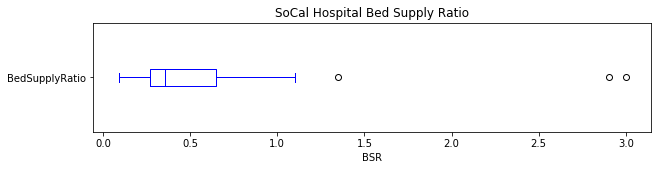

In [193]:
dfBSR.plot(kind='box', figsize=(10, 2), color='blue', vert=False)

plt.title('SoCal Hospital Bed Supply Ratio')
plt.xlabel('BSR')

plt.show()

Add now plot on a scatter plot to identify possible groupings...

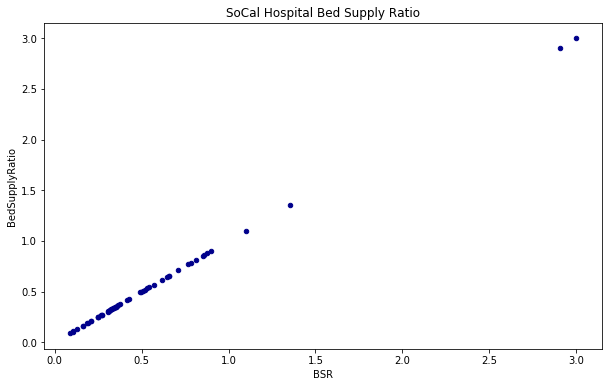

In [194]:
dfBSR.plot(kind='scatter', x='BedSupplyRatio', y="BedSupplyRatio", figsize=(10, 6), color='darkblue')
#plt.ylim(0,)
plt.title('SoCal Hospital Bed Supply Ratio')
plt.xlabel('BSR')
plt.ylabel('BedSupplyRatio')

plt.show()

We can see some clustering of the data into three or four groups; we'll look at that further in a moment.  Also, there are two clear outliers (La Canada Flintridge and the VA).

Let's return to our data and identify the 10 cities least at risk for COVID-19 

In [195]:
df_CALC.sort_values(by='BedSupplyRatio', ascending=False, axis=0, inplace=True) 
df_top15 = df_CALC.head(10) #couldn't shoot a screenshot of 15 
df_top15.head(2)

TotalPopulation  TotalBeds  MaxBeds  BedSupplyRatio
City                                                                        
Veterans Administration            916.0      945.0     10.0        94.50000
La Cañada Flintridge             20423.0      616.0    212.0         2.90566

In [196]:
df_top15_BSR=pd.DataFrame(df_top15[['BedSupplyRatio']])
df_top15_BSR.head(2)

BedSupplyRatio
City                                   
Veterans Administration        94.50000
La Cañada Flintridge            2.90566

Again, let's reset our extreme outlier so our bar graph looks better

In [197]:
df_top15_BSR.iat[0,0]

94.5

In [198]:
df_top15_BSR.iat[0,0]=3

In [199]:
df_top15_BSR1=pd.DataFrame(df_top15_BSR) 

In [200]:
#to get horizontal bar to have largest values at top, had to sort df in descending order!
df_top15_BSR1.sort_values(by='BedSupplyRatio', ascending=True, axis=0, inplace=True) 
df_top15_BSR1

BedSupplyRatio
City                                   
Duarte                         0.783394
San Pedro                      0.813714
Westwood                       0.850860
Hollywood                      0.859044
Harbor City                    0.877133
West Hollywood                 0.900716
East Hollywood                 1.101523
Boyle Heights                  1.350860
La Cañada Flintridge           2.905660
Veterans Administration        3.000000

In [202]:
df_top15_BSR1.head(2)

BedSupplyRatio
City                     
Duarte           0.783394
San Pedro        0.813714

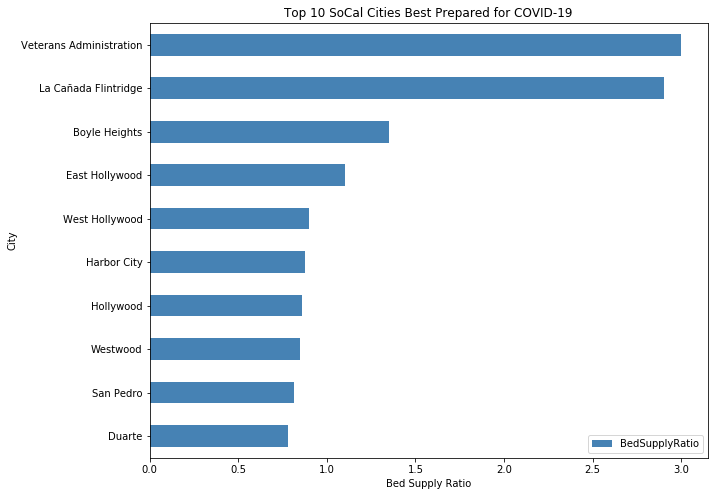

In [225]:
#plot using horizontal bar
### type your answer here
import matplotlib.pyplot as plt
df_top15_BSR1.plot(kind='barh', figsize=(10, 8), color='steelblue') 

plt.xlabel('Bed Supply Ratio')
plt.title('Top 10 SoCal Cities Best Prepared for COVID-19')

for index, value in enumerate(df_top15_BSR1): 
    label = format(value) # format int with commas
    
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    #plt.annotate(label, xy=(value, index), color='black')

plt.show()

Let's create a table that shows Cities, Population, Beds, and BedSupplyRatio

In [204]:
df_TABLE = pd.DataFrame(df_CALC)

In [205]:
df_TABLE.sort_values(by='BedSupplyRatio', ascending=False, axis=0, inplace=True) 

In [206]:
df_TABLE.head(12)

TotalPopulation  TotalBeds  MaxBeds  BedSupplyRatio
City                                                                        
Veterans Administration            916.0      945.0     10.0       94.500000
La Cañada Flintridge             20423.0      616.0    212.0        2.905660
Boyle Heights                   100534.0     1413.0   1046.0        1.350860
East Hollywood                   37898.0      434.0    394.0        1.101523
West Hollywood                   93914.0      880.0    977.0        0.900716
Harbor City                      28185.0      257.0    293.0        0.877133
Hollywood                       195084.0     1743.0   2029.0        0.859044
Westwood                         50288.0      445.0    523.0        0.850860
San Pedro                        84123.0      712.0    875.0        0.813714
Duarte                           26601.0      217.0    277.0        0.783394
Tarzana                          30804.0      246.0    320.0        0.768750
Westlake                         49492.0      366.0    515.0        0.710680

Let's use kmean clustering to group our communities by BSR

In [207]:
dfBSR.head()

BedSupplyRatio
City                                   
Veterans Administration        3.000000
La Cañada Flintridge           2.905660
Boyle Heights                  1.350860
East Hollywood                 1.101523
West Hollywood                 0.900716

In [208]:
dfBSR.tail()

BedSupplyRatio
City                            
Wilshire-La Brea             NaN
Wilsona Gardens              NaN
Windsor Hills                NaN
Windsor Square               NaN
Winnetka                     NaN

In [209]:
dfBSR.shape

(313, 1)

In [210]:
#only need data to run kmeans so use dfBSR, remove NaN values
dfBSR1=dfBSR.dropna()
dfBSR1.shape

(56, 1)

In [211]:
dfBSR1.head()

BedSupplyRatio
City                                   
Veterans Administration        3.000000
La Cañada Flintridge           2.905660
Boyle Heights                  1.350860
East Hollywood                 1.101523
West Hollywood                 0.900716

In [212]:
df_BSR1= dfBSR1 #use this to merge in data clusters

In [213]:
kclusters = 6
#toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
#kmeans.labels_[0:10] 
bsr_clustering = dfBSR1
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bsr_clustering)
kmeans.labels_[0:20] 

array([1, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4],
      dtype=int32)

In [214]:
#step two of clustering-- add cluster label and merge to get lat/long
df_BSR1.insert(0, 'Cluster Labels', kmeans.labels_)
BSR_merged = pd.merge( df_BSR1,df_hosp1, on=['City'], how='left')
BSR_merged.set_index('City')
BSR_merged.reset_index
BSR_merged.head()

City  Cluster Labels  BedSupplyRatio  \
0  Veterans Administration               1         3.00000   
1     La Cañada Flintridge               1         2.90566   
2     La Cañada Flintridge               1         2.90566   
3            Boyle Heights               3         1.35086   
4            Boyle Heights               3         1.35086   

                                        HospitalName  ZipCode   Latitude  \
0  VA Greater Los Angeles Healthcare System  West...    90073  34.047863   
1                          Adventist Health Glendale    91020  34.205188   
2                         USC Verdugo Hills Hospital    91208  34.204508   
3                               Keck Hospital of USC    90033  34.062726   
4  Los Angeles County and University of Southern ...    90033  34.059281   

    Longitude  StaffedBeds  
0 -118.245353          945  
1 -118.219972          451  
2 -118.216223          165  
3 -118.201888          330  
4 -118.209219          670

In [215]:
BSR_merged

City  Cluster Labels  BedSupplyRatio  \
0   Veterans Administration               1        3.000000   
1      La Cañada Flintridge               1        2.905660   
2      La Cañada Flintridge               1        2.905660   
3             Boyle Heights               3        1.350860   
4             Boyle Heights               3        1.350860   
5             Boyle Heights               3        1.350860   
6             Boyle Heights               3        1.350860   
7            East Hollywood               3        1.101523   
8            West Hollywood               2        0.900716   
9               Harbor City               2        0.877133   
10                Hollywood               2        0.859044   
11                Hollywood               2        0.859044   
12                Hollywood               2        0.859044   
13                 Westwood               2        0.850860   
14                 Westwood               2        0.850860   
15                San Pedro               2        0.813714   
16                   Duarte               2        0.783394   
17                  Tarzana               2        0.768750   
18                 Westlake               2        0.710680   
19         East Los Angeles               4        0.658394   
20         East Los Angeles               4        0.658394   
21            Mission Hills               4        0.654514   
22                   Downey               4        0.648211   
23                   Downey               4        0.648211   
24                   Downey               4        0.648211   
25                   Covina               4        0.615018   
26                 Torrance               4        0.568490   
27                 Torrance               4        0.568490   
28                 Torrance               4        0.568490   
29                Echo Park               4        0.544199   
30                Echo Park               4        0.544199   
31                Echo Park               4        0.544199   
32         West Los Angeles               4        0.531062   
33                  Fairfax               4        0.516456   
34                  Lynwood               4        0.506775   
35            Panorama City               4        0.493878   
36            Panorama City               4        0.493878   
37            Monterey Park               4        0.492089   
38            Monterey Park               4        0.492089   
39                 Glendora               0        0.425182   
40                 Glendora               0        0.425182   
41              San Gabriel               0        0.413011   
42               Northridge               0        0.374169   
43              Culver City               0        0.365437   
44                 Valencia               0        0.360061   
45               Ocean Park               0        0.352740   
46                  Burbank               0        0.349065   
47                 Pasadena               0        0.346341   
48               Montebello               0        0.340944   
49           Woodland Hills               0        0.333775   
50                 Whittier               0        0.330783   
51                 Whittier               0        0.330783   
52              West Covina               0        0.326011   
53              West Covina               0        0.326011   
54             Baldwin Park               0        0.319652   
55                   Encino               0        0.316239   
56                   Pomona               0        0.311016   
57                   Pomona               0        0.311016   
58          East Long Beach               0        0.305623   
59        Lake View Terrace               0        0.303091   
60               West Hills               0        0.272727   
61             Santa Monica               0        0.270876   
62                San Dimas               0        0.2

In [216]:
BSR_merged.shape

(80, 8)

In [217]:
#drop duplicates only need to cluster/map one value 
BSR_merged=BSR_merged.drop_duplicates(['City'], keep='last')

In [218]:
BSR_merged.shape
#now we have fifty-six cities as expected

(56, 8)

In [219]:
BSR_merged.head()

City  Cluster Labels  BedSupplyRatio  \
0  Veterans Administration               1        3.000000   
2     La Cañada Flintridge               1        2.905660   
6            Boyle Heights               3        1.350860   
7           East Hollywood               3        1.101523   
8           West Hollywood               2        0.900716   

                                        HospitalName  ZipCode   Latitude  \
0  VA Greater Los Angeles Healthcare System  West...    90073  34.047863   
2                         USC Verdugo Hills Hospital    91208  34.204508   
6             USC Norris Comprehensive Cancer Center    90033  33.977221   
7          CHA Hollywood Presbyterian Medical Center    90029  34.096341   
8                         CedarsSinai Medical Center    90048  34.075160   

    Longitude  StaffedBeds  
0 -118.245353          945  
2 -118.216223          165  
6 -118.391166           60  
7 -118.290078          434  
8 -118.381094          880

In [220]:
#step three of clustering --map still using LA lat,long from way above...
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(BSR_merged['Latitude'], BSR_merged['Longitude'], BSR_merged['City'], BSR_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In the cluster map above, purple indicates the highest BedSupplyRatio (~3).  followed in descending order by sky blue (BSR ~1), blue (> 0.7), green (0.5-0.7), red (0.2-0.4)  and orange (< 0.2), 

## Results and Discussion <a name="results"></a>

**Overall, the Southern California region is not well prepared for COVID-19.**   *It only has 12% of the maximum hospital beds it likely will need for hospitalized COVID-19 patients.*  Thus, additional beds must be created and/or other steps taken (e.g. social distancing) to ensure the actual level of hospitalization remains below the number of available beds.

Looking at specific communities in the region, turns out over 80% (roughly 250 out of 300) do not have any hospitals at all and thus must rely on nearby hospitals to serve their population should they become ill.  Almost every SoCal community is at risk for COVID-19, making a Top 10 neighborhoods at risk list moot.  

Instead, a Top 10 graph was created showing those communities who are the most prepared to handle COVID-19 for their populations.  One 'community' (the Veterans Administration) actually had more hospital beds than residents.  This 'community' is really a hospital complex that is large enough in area to have its own zip code.  The Top 10 cities can provide at least 75% of the hospital beds required for their population and so do not need to take immediate additional measures.

On average, the 56 SoCal communities that do have hospitals can provide 53% of the hospital beds their population requires.  

Looking at the map of hospitals in SoCal, we see a fairly even distribution of hospitals in the region.  The shaded map showing calculated BedSupplyRatio (TotalBeds/MaxBeds) for each zip code also indicates areas that can cover their hospitalization needs are spread out geographically.  The cluster map confirms the reasonable spacing of relatively well-prepared communities.


## Conclusion <a name="conclusion"></a>

This project set out to identify where in the SoCal region leaders might need to take extra action to ensure their communities could deal well with COVID-19.  Using population and hospital bed information by zip code, it has provided maps and tables to allow such decisions to be made.  **Almost all communities in SoCal, need to take extra steps**--as they do not have enough hospital beds to cover the maximum hospitalization from COVID-19.

This project only looked at one factor (hospital beds) that has been identified as key in combating COVID-19.  Further analysis of other factors such as age, health of population, population density should be considered along with hospital beds to determine a more complete assessment of neighborhood risk. 